# Tutorial 1: Viga en voladizo con carga en el extremo

En este primer tutorial resolveremos el problema clásico de una **viga en voladizo** de sección rectangular, empotrada en un extremo y sometida a una **carga vertical distribuida** en el extremo libre. El objetivo:

* Aprender a utilizar las clases para definir la geometría, las condiciones de borde, las cargas y resolver el problema.
* Validar la solución numérica comparándola con la **solución analítica** de la teoría de vigas de Euler-Bernoulli y estudiar la **convergencia** del elemento triangular lineal (CST) al refinar la malla.

## 1. Descripción del problema físico

Consideramos una viga recta de longitud $L = 1.0\,\text{m}$, altura (canto) $H = 0.2\,\text{m}$ y espesor (fuera del plano) $t = 0.1\,\text{m}$. El material es acero con módulo de Young $E = 210\,\text{GPa}$ y coeficiente de Poisson $\nu = 0.3$.

La viga está **empotrada** en el extremo izquierdo ($x = 0$), es decir, todos los desplazamientos ($u_x, u_y$) son nulos en esa cara. En el extremo derecho ($x = L$) se aplica una **carga distribuida vertical** (hacia abajo) de intensidad $q = 300\,000\,\text{N/m}$ a lo largo de la altura. Esto equivale a una fuerza resultante total $F_\text{total} = q \cdot H = 60\,000\,\text{N}$ actuando en el extremo libre.

## 2. Solución analítica (teoría de vigas)

Para una viga en voladizo de sección constante, con una carga puntual $F$ aplicada en el extremo libre, la **deflexión máxima** (en el punto de aplicación) viene dada por:

$$
v_{\text{exacto}} = -\frac{F L^3}{3 E I}
$$

donde $I$ es el momento de inercia de la sección transversal. Para una sección rectangular de ancho $t$ (espesor) y altura $H$:

$$
I = \frac{t H^3}{12}
$$

El signo negativo indica que la deflexión es hacia abajo (sentido $-y$).

La **distribución de esfuerzo normal** $\sigma_{xx}$ en una sección cualquiera (por ejemplo, en el empotramiento) es lineal con la coordenada vertical $y$:

$$
\sigma_{xx}(y) = \frac{M \cdot (y - y_{\text{neutro}})}{I}, \qquad M = F \cdot x
$$

En el empotramiento ($x = 0$) el momento flector es máximo: $M_{\text{emp}} = F \cdot L$. Tomando el eje neutro en $y = H/2$, se obtiene:

$$
\sigma_{xx}(y) = \frac{F L}{I}\left(y - \frac{H}{2}\right)
$$

Estas expresiones nos servirán para comparar con los resultados del modelo de elementos finitos.

## 3. Implementación

A continuación se muestra el código completo, dividido en secciones lógicas. Cada parte está comentada de forma breve pero suficiente para entender su propósito.

### 3.1 Importación de módulos y definición de parámetros

Comenzamos importando `numpy` y las clases. Definimos todas las constantes físicas y geométricas en unidades SI coherentes.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from femppp import *   # asume que las clases FEMProblem, TriangularElement, Tessellation están disponibles

# ------------------------------------------------------------
# Parámetros del problema (m, N, Pa)
# ------------------------------------------------------------
L = 1.0          # longitud
H = 0.2          # altura
t = 0.1          # espesor
E = 210e9        # módulo de Young
nu = 0.3         # coeficiente de Poisson
q = 300000.0     # carga distribuida en el extremo (N/m a lo largo de la altura)
F_total = q * H  # fuerza resultante en el extremo

### 3.2 Generación de la malla

Usamos una malla estructurada rectangular que luego triangulamos mediante la clase `Tessellation` (que internamente utiliza `scipy.spatial.Delaunay`). Elegimos una resolución moderada para empezar.

Viga: 540 nodos, 1525 elementos triangulares


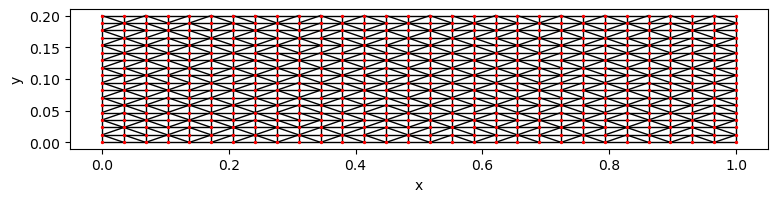

In [9]:
# ------------------------------------------------------------
# Malla estructurada de triángulos
# ------------------------------------------------------------
nx, ny = 30, 18          # divisiones en dirección x e y
x = np.linspace(0.0, L, nx)
y = np.linspace(0.0, H, ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.ravel(), Y.ravel()))

tess = Tessellation(points)
print(f"Viga: {tess.n_nodes} nodos, {tess.n_elements} elementos triangulares")

# Visualización de la malla (opcional)
tess.plot(show_node_ids=False, show_element_ids=False, node_size=2, figure_size=(9,6))


### 3.3 Creación de los elementos finitos

Recorremos la lista de triángulos (`tess.simplices`) y creamos un objeto `TriangularElement` para cada uno. Pasamos las coordenadas nodales globales, las propiedades del material y el espesor.


In [10]:
# ------------------------------------------------------------
# Crear objetos de elemento finito (CST)
# ------------------------------------------------------------
elements = []
for tri in tess.simplices:
    elem = TriangularElement(
        node_ids=tri,
        nodes=tess.points,
        E=E,
        nu=nu,
        thickness=t,
        element_type="CST"
    )
    elements.append(elem)

### 3.4 Ensamblaje y condiciones de contorno

Construimos el objeto `FEMProblem`, que ensamblará la matriz de rigidez global y el vector de fuerzas. Luego aplicamos:

* **Empotramiento izquierdo**: fijamos $u_x = u_y = 0$ en todos los nodos con $x \approx 0$.
* **Carga distribuida vertical** en el borde derecho: definimos una carga con ángulo $-90^\circ$ (hacia abajo) y magnitud $q$.

In [11]:
# ------------------------------------------------------------
# Construir el problema y aplicar condiciones
# ------------------------------------------------------------
problem = FEMProblem(elements)
problem.assemble_stiffness()

# Empotramiento en x = 0
left_nodes = np.where(np.isclose(tess.points[:, 0], 0.0))[0]
dirichlet_values = np.zeros((len(left_nodes), 2))
problem.apply_dirichlet_bcs(nodes=left_nodes, values=dirichlet_values)

# Carga distribuida en x = L (vertical hacia abajo)
right_nodes = np.where(np.isclose(tess.points[:, 0], L))[0]
distributed_loads = [{
    "nodes": right_nodes,
    "angle": -90.0,
    "value": q
}]
problem.apply_distributed_loads(distributed_loads, tess.points)

La matriz del sistema global se puede observar de la siguiente manera:

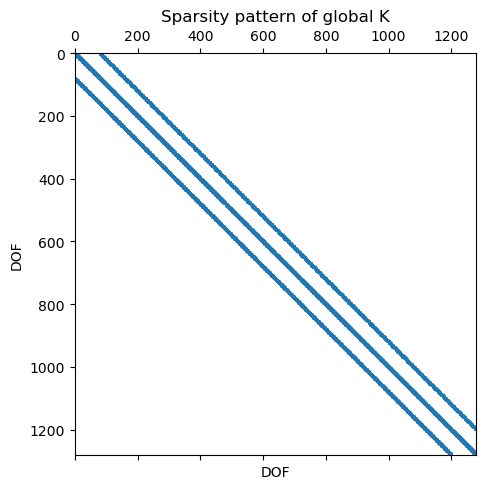

In [24]:
problem.plot_stiffness_sparsity(figsize=(5,5))

### 3.5 Solución del sistema lineal

Resolvemos el sistema de ecuaciones utilizando el método del gradiente conjugado (apto para matrices simétricas definidas positivas). Fijamos una tolerancia estricta para garantizar precisión.

In [12]:
# ------------------------------------------------------------
# Resolver
# ------------------------------------------------------------
problem.solve(method="cg", tol=1e-10)
problem.compute_element_stresses()   # calcula tensiones en cada elemento



### 3.6 Extracción de resultados y comparación con la solución exacta

Obtenemos el desplazamiento vertical en el extremo libre (centro del borde derecho) y calculamos el error relativo respecto a la fórmula analítica.


In [13]:
# ------------------------------------------------------------
# Comparación con solución analítica
# ------------------------------------------------------------
U_global = problem.x   # vector global de desplazamientos

# Buscar nodo en el extremo derecho, preferiblemente en y = H/2
tol_coord = 1e-6
candidates = np.where(
    (np.abs(tess.points[:, 0] - L) < tol_coord) &
    (np.abs(tess.points[:, 1] - H/2) < tol_coord)
)[0]
if len(candidates) == 0:
    # Si no existe, tomar el nodo superior derecho
    candidates = np.where(
        (np.abs(tess.points[:, 0] - L) < tol_coord) &
        (np.abs(tess.points[:, 1] - H) < tol_coord)
    )[0]
tip_idx = candidates[0]

v_fem = U_global[2 * tip_idx + 1]   # componente vertical

# Deflexión teórica
I = t * H**3 / 12.0
v_exact = -F_total * L**3 / (3 * E * I)
error = abs((v_fem - v_exact) / v_exact) * 100

print("\n--- Deflexión en el extremo libre ---")
print(f"  FEM      : {v_fem:.4e} m")
print(f"  Exacta   : {v_exact:.4e} m")
print(f"  Error rel: {error:.2f} %")



--- Deflexión en el extremo libre ---
  FEM      : -1.4101e-03 m
  Exacta   : -1.4286e-03 m
  Error rel: 1.29 %



### 3.7 Visualización de resultados

Podemos dibujar el contorno deformado (amplificado) y la distribución de la tensión de von Mises.


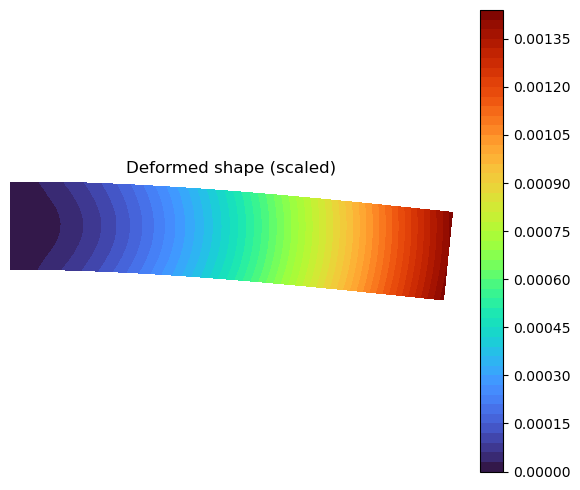

In [16]:
# Contorno deformado (escala 50x)
plot_deformed_contour(
    tess.points,
    tess.simplices,
    problem.ux,
    problem.uy,
    scale = 50
)

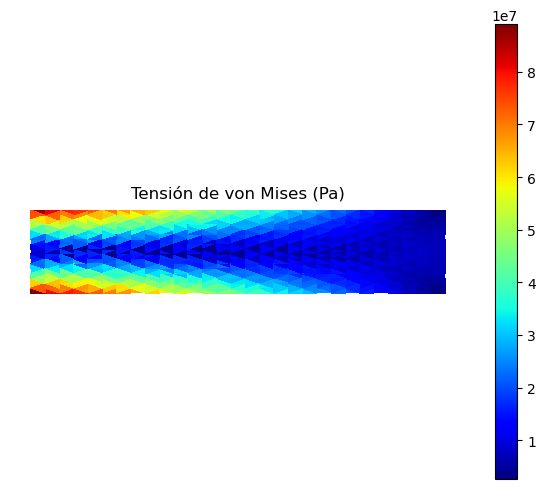

In [18]:
# Tensión de von Mises por elemento
problem.plot_elemental_variable(
    tess.points,
    tess.simplices,
    problem.sigma_vm,
    title = "Tensión de von Mises (Pa)"
)


## 4. Estudio de convergencia

Para observar cómo se comporta el elemento CST al refinar la malla, repetimos el análisis con varias discretizaciones y registramos el error en la deflexión.


In [19]:
# ------------------------------------------------------------
# Lista de refinamientos (nx, ny) con nx ≈ 5*ny
# ------------------------------------------------------------
refinements = [
    (10, 4),
    (20, 8),
    (30, 12),
    (40, 16),
]

results = []

for nx, ny in refinements:
    print(f"\n--- Malla: nx={nx}, ny={ny} ---")
    
    # Generar puntos
    x = np.linspace(0.0, L, nx)
    y = np.linspace(0.0, H, ny)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack((X.ravel(), Y.ravel()))
    tess = Tessellation(points)
    
    # Crear elementos
    elements = []
    for tri in tess.simplices:
        elements.append(TriangularElement(
            node_ids=tri, nodes=tess.points,
            E=E, nu=nu, thickness=t, element_type="CST"
        ))
    
    # Ensamblar y resolver
    problem = FEMProblem(elements)
    problem.assemble_stiffness()
    
    # Condiciones de borde
    left_nodes = np.where(np.isclose(tess.points[:, 0], 0.0))[0]
    problem.apply_dirichlet_bcs(left_nodes, np.zeros((len(left_nodes), 2)))
    
    right_nodes = np.where(np.isclose(tess.points[:, 0], L))[0]
    distributed_loads = [{"nodes": right_nodes, "angle": -90.0, "value": q}]
    problem.apply_distributed_loads(distributed_loads, tess.points)
    
    problem.solve(method="cg", tol=1e-10)
    
    # Deflexión en el extremo
    U_global = problem.x
    # Buscar nodo en (L, H/2)
    for tol in [1e-6, 1e-4, 1e-2]:
        cand = np.where(
            (np.abs(tess.points[:, 0] - L) < tol) &
            (np.abs(tess.points[:, 1] - H/2) < tol)
        )[0]
        if len(cand) > 0:
            tip_idx = cand[0]
            break
    else:
        tip_idx = np.argmax(tess.points[:, 0])   # fallback
    
    v_fem = U_global[2 * tip_idx + 1]
    error = abs((v_fem - v_exact) / v_exact) * 100
    
    results.append({
        'nx': nx, 'ny': ny,
        'n_nodes': tess.n_nodes,
        'n_elements': tess.n_elements,
        'v_fem (m)': v_fem,
        'v_exact (m)': v_exact,
        'error (%)': error
    })
    
    print(f"  Nodos: {tess.n_nodes}, Elementos: {tess.n_elements}")
    print(f"  Deflexión FEM: {v_fem:.3e} m, Error: {error:.3f}%")

# Mostrar tabla
df = pd.DataFrame(results)
print("\nTabla de convergencia:")
df



--- Malla: nx=10, ny=4 ---
  Nodos: 40, Elementos: 93
  Deflexión FEM: -9.622e-04 m, Error: 32.644%

--- Malla: nx=20, ny=8 ---
  Nodos: 160, Elementos: 425
  Deflexión FEM: -1.318e-03 m, Error: 7.714%

--- Malla: nx=30, ny=12 ---
  Nodos: 360, Elementos: 997
  Deflexión FEM: -1.399e-03 m, Error: 2.094%

--- Malla: nx=40, ny=16 ---
  Nodos: 640, Elementos: 1809
  Deflexión FEM: -1.429e-03 m, Error: 0.020%

Tabla de convergencia:


,nx,ny,n_nodes,n_elements,v_fem (m),v_exact (m),error (%)
0,10,4,40,93,-0.000962,-0.001429,32.644491
1,20,8,160,425,-0.001318,-0.001429,7.714052
2,30,12,360,997,-0.001399,-0.001429,2.093543
3,40,16,640,1809,-0.001429,-0.001429,0.020057


### 4.1 Gráfico de convergencia

Representamos el error relativo frente al número de nodos en escala log-log. La pendiente negativa indica la tasa de convergencia del elemento.


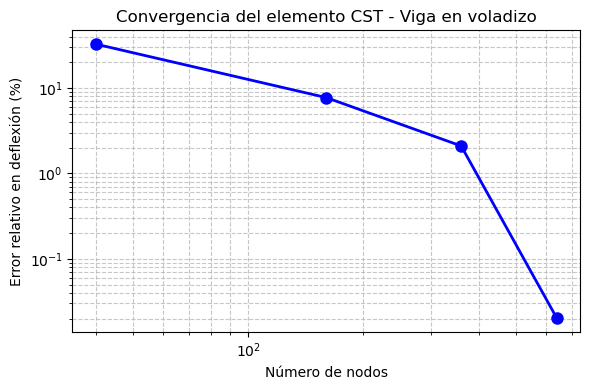

In [21]:
plt.figure(figsize = (6, 4))
plt.loglog(df['n_nodes'], df['error (%)'], 'bo-', linewidth = 2, markersize = 8)
plt.xlabel('Número de nodos')
plt.ylabel('Error relativo en deflexión (%)')
plt.title('Convergencia del elemento CST - Viga en voladizo')
plt.grid(True, which = 'both', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

## 5. Distribución de tensiones en el empotramiento

Finalmente, comparamos la distribución de $\sigma_{xx}$ a lo largo de la altura en la sección empotrada ($x \approx 0$) con la solución analítica. Para ello utilizamos la malla más fina de la lista y promediamos los valores de los elementos en cada nodo (técnica de promedio nodal).

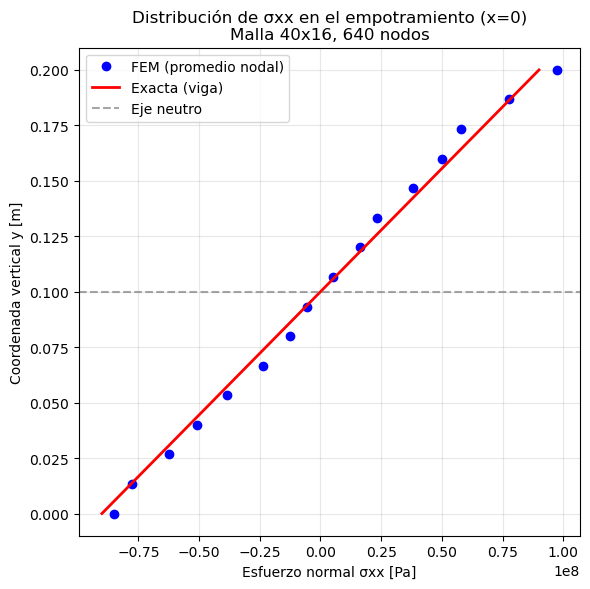

In [23]:
# ------------------------------------------------------------
# Usar la malla más fina (última de refinements)
# ------------------------------------------------------------
nx_fine, ny_fine = refinements[-1]
x_fine = np.linspace(0.0, L, nx_fine)
y_fine = np.linspace(0.0, H, ny_fine)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
points_fine = np.column_stack((X_fine.ravel(), Y_fine.ravel()))
tess_fine = Tessellation(points_fine)

# Crear elementos
elements_fine = []
for tri in tess_fine.simplices:
    elements_fine.append(TriangularElement(
        node_ids=tri, nodes=tess_fine.points,
        E=E, nu=nu, thickness=t, element_type="CST"
    ))

# Ensamblar y resolver
problem_fine = FEMProblem(elements_fine)
problem_fine.assemble_stiffness()

# Condiciones
left_nodes_fine = np.where(np.isclose(tess_fine.points[:, 0], 0.0))[0]
problem_fine.apply_dirichlet_bcs(left_nodes_fine, np.zeros((len(left_nodes_fine), 2)))

right_nodes_fine = np.where(np.isclose(tess_fine.points[:, 0], L))[0]
distributed_loads_fine = [{"nodes": right_nodes_fine, "angle": -90.0, "value": q}]
problem_fine.apply_distributed_loads(distributed_loads_fine, tess_fine.points)

problem_fine.solve(method="cg", tol=1e-10)
problem_fine.compute_element_stresses()

# --- Promedio nodal de σxx ---
sigma_all = problem_fine.element_stress   # (n_elem, 3)
n_nodes_fine = tess_fine.n_nodes
sigma_xx_nodal = np.zeros(n_nodes_fine)
count_nodal = np.zeros(n_nodes_fine, dtype=int)

for elem, stress in zip(elements_fine, sigma_all):
    for node_id in elem.node_ids:
        sigma_xx_nodal[node_id] += stress[0]   # σxx
        count_nodal[node_id] += 1

count_nodal[count_nodal == 0] = 1
sigma_xx_nodal /= count_nodal

# Extraer nodos en el borde izquierdo
left_mask = np.isclose(tess_fine.points[:, 0], 0.0)
left_indices = np.where(left_mask)[0]
y_left = tess_fine.points[left_indices, 1]
sigma_left = sigma_xx_nodal[left_indices]

# Ordenar por coordenada y
sort_idx = np.argsort(y_left)
y_left_sorted = y_left[sort_idx]
sigma_left_sorted = sigma_left[sort_idx]

# Solución exacta en el empotramiento
M_emp = F_total * L
y_exact = np.linspace(0, H, 100)
sigma_exact = M_emp * (y_exact - H/2) / I

# Graficar
plt.figure(figsize=(6,6))
plt.plot(sigma_left_sorted, y_left_sorted, 'bo', markersize=6, label='FEM (promedio nodal)')
plt.plot(sigma_exact, y_exact, 'r-', linewidth=2, label='Exacta (viga)')
plt.axhline(y=H/2, color='gray', linestyle='--', alpha=0.7, label='Eje neutro')
plt.xlabel('Esfuerzo normal σxx [Pa]')
plt.ylabel('Coordenada vertical y [m]')
plt.title(f'Distribución de σxx en el empotramiento (x=0)\nMalla {nx_fine}x{ny_fine}, {n_nodes_fine} nodos')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
